# Exploratory Data Analysis for Final Project

In this assignment, your task is to put your new skils to use in the form of an open-ended, exploratory data analysis. In particular, I'm looking for you to demonstrate your ability to use the programmatic tools we've been learning to access data, manipulate it, and visualize some findings while working towards the ultimate goal of developing a final project proposal. Please include the following in your assignment:

  1. A brief summary of the topic (a few sentences)
  2. Access 2 or more datasets, at least one of them using an API (if you are not using any data from an API as part of your project yet, don’t worry about it, and just do this to get some exercise using APIs. You might use it later).
  3. Demonstrate the use of Pandas operations to filter out missing data and/or outliers.
  4. Demonstrate your capacity to use some of the "group-by" operations to produce pivot tables or statistical summaries of your data.
  5. Use Matplotlib or Seaborn to produce 2-3 data visualizations of your data to both explore the data and highlight any notable patterns.
  6. Include a short written analysis of your interpretation of the data.
  7. In a few paragraphs, describe the research question you intend to investigate in your final project, and the plan for the data analysis you intend to perform.

Note that this exercise is intended to help you formulate your project topic. But it is not a binding contract. Your project will most likely evolve over the rest of the semester. So use this as an opportunity to be creative, throw some ideas against the wall and see what sticks. I will release the final project guidelines shortly. In the meantime, dig in!

And as always, please submit this assignment both as a PR on GitHub along with the URL of your PR on bCourses.

In [1]:
!pip install mapbox
!pip install haversine


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: C:\Users\Cedric\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: C:\Users\Cedric\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
from mapbox import Geocoder
from mapbox import Directions
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.parser import parse
import folium
from haversine import haversine, Unit
from folium.plugins import HeatMap
import seaborn as sns
import csv

I am interested in urban mobility, so the data I am looking for for this assignment are all related to trajectory analysis. Currently, I am conducting exploratory analysis on these data. I also want to focus on mobility in the future final project. I still need to do more details. to dig

# Part 1: Mapbox API Location Data

use mapbox api to get the lon & lat of my home place and wurster hall 

In [3]:
geocoder = Geocoder(access_token='sk.eyJ1IjoiemV5dXd1MjAwMSIsImEiOiJjbHRtMjNjc3UxamdmMnFrOWlldjV0OWp5In0.JbBNwuCMXjFxvxivi4nHeQ')

addresses = ['1906 Bonita Ave, Berkeley, CA', 'Wurster Hall, Berkeley, CA']  # List of addresses
data = []

# Geocode address to lon & lat
for address in addresses:
    response = geocoder.forward(address)
    feature = response.geojson()['features'][0]  # Assuming the top result is the correct one
    data.append({
        'address': address,
        'longitude': feature['geometry']['coordinates'][0],
        'latitude': feature['geometry']['coordinates'][1]
    })
'''
# Save the data to a CSV file
with open('geocoded_addresses.csv', 'w', newline='') as csvfile:
    fieldnames = ['address', 'longitude', 'latitude']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for item in data:
        writer.writerow(item)
'''
data

[{'address': '1906 Bonita Ave, Berkeley, CA',
  'longitude': -122.272393,
  'latitude': 37.87314},
 {'address': 'Wurster Hall, Berkeley, CA',
  'longitude': -122.254896,
  'latitude': 37.870739}]

use mapbox api to get the driving direction from my home place to wurster hall 

In [4]:
service = Directions(access_token='sk.eyJ1IjoiemV5dXd1MjAwMSIsImEiOiJjbHRtMjNjc3UxamdmMnFrOWlldjV0OWp5In0.JbBNwuCMXjFxvxivi4nHeQ')

origin = {'type': 'Feature', 'properties': {}, 'geometry': {'type': 'Point', 'coordinates': [-122.272393, 37.87314]}} 
destination = {'type': 'Feature', 'properties': {}, 'geometry': {'type': 'Point', 'coordinates': [-122.254896, 37.870739]}}
response = service.directions([origin, destination], 'mapbox/driving')
driving_directions = response.geojson()
driving_directions

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'geometry': {'type': 'LineString',
    'coordinates': [(-122.27206, 37.87316),
     (-122.27209, 37.87346),
     (-122.26475, 37.87433),
     (-122.26392, 37.87459),
     (-122.25682, 37.87552),
     (-122.25659, 37.87515),
     (-122.256, 37.87463),
     (-122.25529, 37.87366),
     (-122.25457, 37.87301),
     (-122.25391, 37.87266),
     (-122.25299, 37.87195),
     (-122.25286, 37.8718),
     (-122.25276, 37.87129),
     (-122.25357, 37.87122),
     (-122.25399, 37.8713),
     (-122.25495, 37.87111)]},
   'properties': {'distance': 2203.81, 'duration': 528.785}}]}

In [5]:
access_token = 'sk.eyJ1IjoiemV5dXd1MjAwMSIsImEiOiJjbHRtMjNjc3UxamdmMnFrOWlldjV0OWp5In0.JbBNwuCMXjFxvxivi4nHeQ'
service = Directions(access_token=access_token)

origin = [-122.272393, 37.87314]  # My Home
destination = [-122.254896, 37.870739]  # Wurster Hall

# Get the driving directions
response = service.directions([{
    'type': 'Feature',
    'properties': {},
    'geometry': {
        'type': 'Point',
        'coordinates': origin
    }
}, {
    'type': 'Feature',
    'properties': {},
    'geometry': {
        'type': 'Point',
        'coordinates': destination
    }
}], 'mapbox/driving')

# Extract the route line
directions_data = response.geojson()
route_line = directions_data['features'][0]['geometry']['coordinates']

# Convert the route line to a format compatible with Folium
route_line_swapped = [[point[1], point[0]] for point in route_line]  # Swap lat and lon

# Create a map centered around the route
map_center = [(origin[1] + destination[1]) / 2, (origin[0] + destination[0]) / 2]
m = folium.Map(location=map_center, zoom_start=15)

# Add the route to the map
folium.PolyLine(route_line_swapped, color="blue", weight=2.5, opacity=1).add_to(m)

# Add markers for the start and end points
folium.Marker(location=[origin[1], origin[0]], popup='Start', icon=folium.Icon(color='orange')).add_to(m)
folium.Marker(location=[destination[1], destination[0]], popup='End', icon=folium.Icon(color='pink')).add_to(m)

m

In [6]:
access_token = 'sk.eyJ1IjoiemV5dXd1MjAwMSIsImEiOiJjbHRtMjNjc3UxamdmMnFrOWlldjV0OWp5In0.JbBNwuCMXjFxvxivi4nHeQ'

mapbox_style_url = 'mapbox/dark-v10'  # Use Mapbox Dark style for the tiles
service = Directions(access_token=access_token)

origin = [-122.272393, 37.87314]  # My Home
destination = [-122.254896, 37.870739]  # Wurster Hall

profiles = ['mapbox/driving', 'mapbox/driving-traffic', 'mapbox/walking', 'mapbox/cycling']  # Define the route profiles

# Create a map 
map_center = [(origin[1] + destination[1]) / 2, (origin[0] + destination[0]) / 2]
m = folium.Map(location=map_center, zoom_start=15, tiles=f"https://api.mapbox.com/styles/v1/{mapbox_style_url}/tiles/{{z}}/{{x}}/{{y}}?access_token={access_token}", attr='Mapbox')

# Define colors for the different routes
colors = ['purple', 'green', 'red', 'blue']  # Added a color for routes

# Loop through the profiles and add each route to the map
for profile, color in zip(profiles, colors):
    # Get the directions
    response = service.directions([{
        'type': 'Feature',
        'properties': {},
        'geometry': {
            'type': 'Point',
            'coordinates': origin
        }
    }, {
        'type': 'Feature',
        'properties': {},
        'geometry': {
            'type': 'Point',
            'coordinates': destination
        }
    }], profile)

    directions_data = response.geojson()
    route_line = directions_data['features'][0]['geometry']['coordinates']    # Extract the route line

    # Convert the route line to a format compatible with Folium
    route_line_swapped = [[point[1], point[0]] for point in route_line]  # Swap lat and lon

    # Add the route to the map
    folium.PolyLine(route_line_swapped, color=color, weight=2.5, opacity=1, popup=profile).add_to(m)

# Add markers for the start and end points
folium.Marker(location=[origin[1], origin[0]], popup='Start', icon=folium.Icon(color='orange')).add_to(m)
folium.Marker(location=[destination[1], destination[0]], popup='End', icon=folium.Icon(color='pink')).add_to(m)

m

In this part, I used mapbox API to get the data of real life address, but normally people do not know the lon & lat of our real life location, so I utiliezd the mapbox to do the tranform the address, and then I am also curious how can I visualize the line of two different locations, then I also utlized mapbox API to visualize the differnt routes of the data.

# Part 2: Hangzhou taxi trajectory

In [7]:
df = pd.read_csv("00new.csv.csv", encoding='GBK', index_col=0)
df.head()

,UNIQUEID,DeviceType,Company,DeviceID,Flag,FilterFlag,EvelationFlag,Satellite,Heading,Speed,EvelationUnit,Evelation,Status,Event,Longitude,Latitude,BJ-Longitude,BJ-Latitude,TimeStamp
DataTime,,,,,,,,,,,,,,,,,,,
1427817600,201503312359_126_6512_7283838,1,33010001,200339.0,0,0,0,0,259,64,0,50,0,4,1191148070,293127530,1191200308,293102620,1427817538
1427817600,201503312359_126_6512_7283839,1,33010001,24657.0,0,0,0,0,45,0,0,50,0,4,1201566830,302947000,1201613746,302923704,1427838401
1427817600,201503312359_126_6512_7283841,1,33010001,NaN,0,0,0,0,130,3,0,50,0,4,1201161900,303115840,1201209808,303093113,1427817538
1427817600,201503312359_126_6512_7283842,1,33010001,17330.0,0,0,0,0,90,0,0,50,0,4,1200847000,303649670,1200895259,303627049,1427838402
1427817600,201503312359_126_6512_7283843,1,33010001,14863.0,0,0,0,0,100,0,0,50,1,4,1201665700,302605320,1201712295,302581808,1427817537


In [8]:
df.isnull().sum()

UNIQUEID           0
DeviceType         0
Company            0
DeviceID         556
Flag               0
FilterFlag         0
EvelationFlag      0
Satellite          0
Heading            0
Speed              0
EvelationUnit      0
Evelation          0
Status             0
Event              0
Longitude          0
Latitude           0
BJ-Longitude       0
BJ-Latitude        0
TimeStamp          0
dtype: int64

In [9]:
df[(df.Speed > 150) | (df.Speed < 0)]

,UNIQUEID,DeviceType,Company,DeviceID,Flag,FilterFlag,EvelationFlag,Satellite,Heading,Speed,EvelationUnit,Evelation,Status,Event,Longitude,Latitude,BJ-Longitude,BJ-Latitude,TimeStamp
DataTime,,,,,,,,,,,,,,,,,,,
1427817600,201503312359_111_14710_2980147,1,33010003,1.200762e+09,0,0,0,0,199,256,0,50,4,4,423396367,35591993,423465302,35592796,1427816320
1427817600,201503312359_111_14710_2980149,1,33010003,1.200762e+09,0,0,0,0,199,256,0,50,4,4,423345167,35591993,423414035,35592701,1427829504
1427817600,201503312359_111_14710_2980151,1,33010003,1.200762e+09,0,0,0,0,199,256,0,50,4,4,423378447,35591994,423447359,35592764,1427795328
1427817600,201503312359_111_14710_2980153,1,33010003,1.200762e+09,0,0,0,0,199,256,0,50,4,4,423288847,35591994,423357641,35592596,1427803392
1427817600,201503312359_111_14710_2980155,1,33010003,1.200762e+09,0,0,0,0,199,256,0,50,4,4,423278607,35591994,423347387,35592576,1427785088
1427817600,201503312359_111_14710_2980157,1,33010003,1.200762e+09,0,0,0,0,199,256,0,50,4,4,423245327,35591994,423314063,35592513,1427809280
1427817600,201503312359_111_14710_2980159,1,33010003,1.200762e+09,0,0,0,0,199,256,0,50,4,4,423214607,35591994,423283302,35592456,1427799424
1427817600,201503312359_111_14710_2980161,1,33010003,1.200762e+09,0,0,0,0,205,256,0,50,4,4,423204367,35591994,423273049,35592436,1427831680


In [10]:
# Remove invalid data in rows with missing values 
df = df.dropna() 

# Eliminate speed abnormal data
df.drop(df[(df.Speed > 150) & (df.Speed < 0)].index, inplace=True)
# The unit of Speed in the original taxi trajectory data set is 𝑘𝑚/h, and the value range is [0, 512]. T
# Treat data whose speed is not within the value range [0, 150] at the sampling points as abnormal data, and eliminate such abnormal data

# Remove duplicate data
df.drop_duplicates()

# Longitude and latitude normalization
df.Longitude = df.Longitude / 10000000
df.Latitude = df.Latitude / 10000000

# Time normalization
df.TimeStamp = pd.to_datetime(df.TimeStamp,unit='s') 

df.head()

,UNIQUEID,DeviceType,Company,DeviceID,Flag,FilterFlag,EvelationFlag,Satellite,Heading,Speed,EvelationUnit,Evelation,Status,Event,Longitude,Latitude,BJ-Longitude,BJ-Latitude,TimeStamp
DataTime,,,,,,,,,,,,,,,,,,,
1427817600,201503312359_126_6512_7283838,1,33010001,200339.0,0,0,0,0,259,64,0,50,0,4,119.114807,29.312753,1191200308,293102620,2015-03-31 15:58:58
1427817600,201503312359_126_6512_7283839,1,33010001,24657.0,0,0,0,0,45,0,0,50,0,4,120.156683,30.294700,1201613746,302923704,2015-03-31 21:46:41
1427817600,201503312359_126_6512_7283842,1,33010001,17330.0,0,0,0,0,90,0,0,50,0,4,120.084700,30.364967,1200895259,303627049,2015-03-31 21:46:42
1427817600,201503312359_126_6512_7283843,1,33010001,14863.0,0,0,0,0,100,0,0,50,1,4,120.166570,30.260532,1201712295,302581808,2015-03-31 15:58:57
1427817600,201503312359_126_6512_7283845,1,33010001,18348.0,0,0,0,0,250,48,0,50,0,4,120.226070,30.289186,1202305771,302867448,2015-03-31 15:58:57


In [11]:
# Create a folium map 
m = folium.Map(
    location=[30.22795, 120.165], 
    zoom_start=10,               
    control_scale=True,           # Add a scale bar
    tiles='OpenStreetMap'        # CartoDB dark_matter  CartoDB positron  Stamen Terrain
)

# Draw a range rectangle
points = ([30.012, 119.869], [30.012, 120.461], [30.4439, 119.869], [30.4439, 120.461])
folium.Rectangle(bounds=points, color='#ff7800', fill=False, fill_opacity=0.2).add_to(m)

# Mark points one by one on the map
for lat, lng, in zip(df.Latitude, df.Longitude):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='yellow',
        fill=True,
        fill_color='red',
        fill_opacity=0.6
    ).add_to(m)

m

In [12]:
heat_map = folium.Map([30.22795, 120.165], zoom_start=11, control_scale=True, tiles='CartoDB positron')

# Convert data format, assuming df is your DataFrame with 'Latitude' and 'Longitude' columns
heatdata = df[['Latitude','Longitude']].values.tolist()

# - Increase 'radius' to increase the size of each point in the heatmap
# - Adjust 'blur' for smoother appearance
# - Define 'gradient' for custom colorization
# - Set 'min_opacity' for base transparency level
HeatMap(
    heatdata, 
    radius=15,  # Increase the radius of each "heat" point
    blur=20,    # Increase for smoother color transition
    gradient={0.2: 'blue', 0.4: 'cyan', 0.6: 'lime', 0.8: 'yellow', 1: 'red'},  # Color from cool to warm
    min_opacity=0.5  # Set minimum opacity
).add_to(heat_map)

heat_map

Text(0.5, 1.0, 'Traffic Flow')

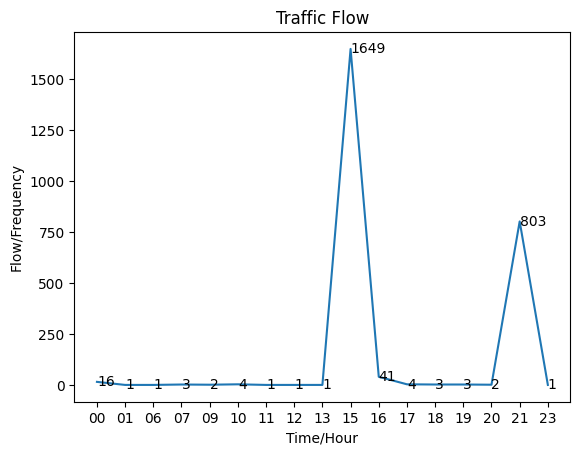

In [13]:
# Copy TimeStamp to extract hour for time
df['time'] = df.TimeStamp
df['hour'] = [x.strftime('%H') for x in df.time] # Hours of extraction time

traffic = df['hour'].drop_duplicates() # Remove duplicate for hours

x = df.groupby('hour')['UNIQUEID'].count() # Find the passenger flow per hour (frequency)
y = x.reset_index() # Reset the index to prepare for drawing the line chart

plt.subplot(1,1,1)
plt.plot(y['hour'],y['UNIQUEID']) 

plt.xlabel('Time/Hour')
plt.ylabel("Flow/Frequency")

for a,b in zip(y['hour'],y['UNIQUEID']): # Set data labels to be displayed on the graph
    plt.text(a,b,b,va='center')
plt.title('Traffic Flow') 

In [14]:
# Pivot table summarizing key metrics by DeviceType
pivot_device_type = df.pivot_table(index='DeviceType', values=['Speed', 'Evelation', 'Heading'], aggfunc='mean')

# Pivot table summarizing key metrics by Company
pivot_company = df.pivot_table(index='Company', values=['Speed', 'Evelation', 'Heading'], aggfunc='mean')

pivot_device_type, pivot_company

(            Evelation    Heading     Speed
 DeviceType                                
 1                50.0  154.03194  18.47989,
           Evelation     Heading      Speed
 Company                                   
 33010001       50.0  150.852071  14.785503
 33010003       50.0  166.726378  33.228346)

C:\Users\Cedric\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Cedric\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Cedric\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Categ

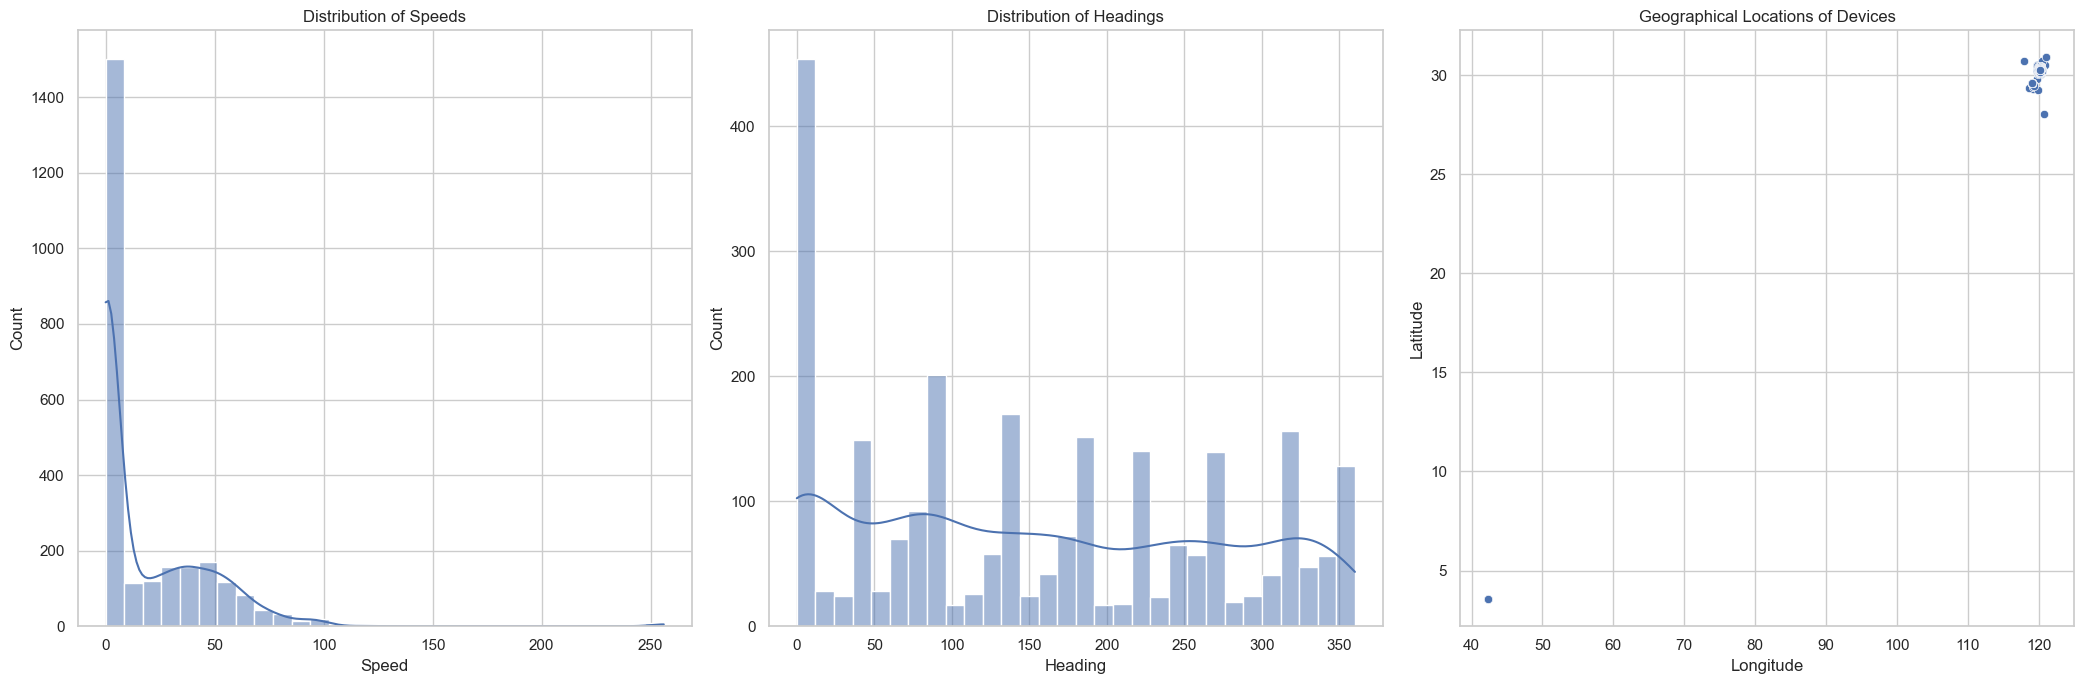

In [15]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 3, figsize=(21, 7))

# Histogram of Speeds
sns.histplot(df['Speed'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Distribution of Speeds')
axes[0].set_xlabel('Speed')
axes[0].set_ylabel('Count')

# Histogram of Headings
sns.histplot(df['Heading'], bins=30, kde=True, ax=axes[1])
axes[1].set_title('Distribution of Headings')
axes[1].set_xlabel('Heading')
axes[1].set_ylabel('Count')

# Scatter plot of Geographical Locations
sns.scatterplot(x='Longitude', y='Latitude', data=df, ax=axes[2], marker='o')
axes[2].set_title('Geographical Locations of Devices')
axes[2].set_xlabel('Longitude')
axes[2].set_ylabel('Latitude')

plt.tight_layout()
plt.show()

In this part, I used the Hangzhou taxi trajectory data set from Baidu Paddle Dataset. The dataset contains information about taxi, including unique identifiers, device type, company, device ID, flags, satellite data, heading, speed, longitude, latitude, timestamps, and other related attributes. The columns include 'UNIQUEID', 'DeviceType', 'Company', 'DeviceID', 'Flag', 'FilterFlag', 'EvelationFlag', 'Satellite', 'Heading', 'Speed', 'Evelation', 'Status', 'Event', 'Longitude', 'Latitude', 'BJ-Longitude', 'BJ-Latitude', 'TimeStamp'.

I first used pandas to clean the data, and used Matplotlib and folium to visualize the spatial distribution patterns of the data. I also used folium's heatmap to draw the data sampling points onto a map to further demonstrate the spatial distribution of taxi data.

After the taxi trajectory data is preprocessed, I extracted the time attribute of the data. The time granularity can be one hour/half hour. Count the number of sampling points within the fine granularity of each time. Use python matplotlib to draw the number of sampling points (i.e., traffic flow ) Discount diagram of dynamic changes over time, statistics of morning peak time interval and evening peak time interval.

I also ploted Distribution of Speeds histogram. It shows that a large number of taxi have speeds close to 0, indicating that many taxi might be stationary or moving very slowly. There's a long tail in the speed distribution, meaning that while most taxi are moving slowly, there are a few that are moving at higher speeds.

# Part 3: Shenzhen taxi trajectory

In [17]:
taxi_data = pd.read_csv("Taxi.csv")

In [18]:
# Assigning proper column names
column_names = ['Taxi_ID', 'Timestamp', 'Longitude', 'Latitude', 'Occupied', 'Unknown']
taxi_data.columns = column_names

summary_info = {
    'Unique_Taxis': taxi_data['Taxi_ID'].nunique(),
    'Time_Range': [taxi_data['Timestamp'].min(), taxi_data['Timestamp'].max()],
    'Record_Count': taxi_data.shape[0],
    'Occupancy_Info': taxi_data['Occupied'].value_counts(normalize=True),
}

summary_info

{'Unique_Taxis': 5,
 'Time_Range': ['00:00:00', '23:59:58'],
 'Record_Count': 10000,
 'Occupancy_Info': Occupied
 1    0.5918
 0    0.4082
 Name: proportion, dtype: float64}

In [19]:
# Basic data summaries
print("Unique Taxis:", taxi_data['Taxi_ID'].nunique())
print("Time Range:", taxi_data['Timestamp'].min(), "to", taxi_data['Timestamp'].max())
print("Record Count:", taxi_data.shape[0])
print("Occupancy Information:", taxi_data['Occupied'].value_counts(normalize=True))

Unique Taxis: 5
Time Range: 00:00:00 to 23:59:58
Record Count: 10000
Occupancy Information: Occupied
1    0.5918
0    0.4082
Name: proportion, dtype: float64


C:\Users\Cedric\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Cedric\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


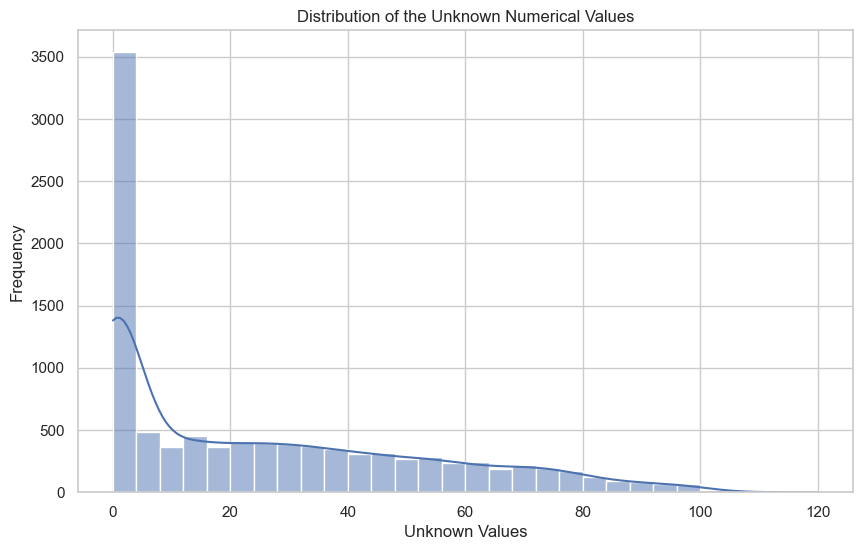

In [20]:
# Plotting the histogram of the 'Unknown' column
plt.figure(figsize=(10, 6))
sns.histplot(taxi_data['Unknown'], bins=30, kde=True)
plt.title('Distribution of the Unknown Numerical Values')
plt.xlabel('Unknown Values')
plt.ylabel('Frequency')
plt.show()

C:\Users\Cedric\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Cedric\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Cedric\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

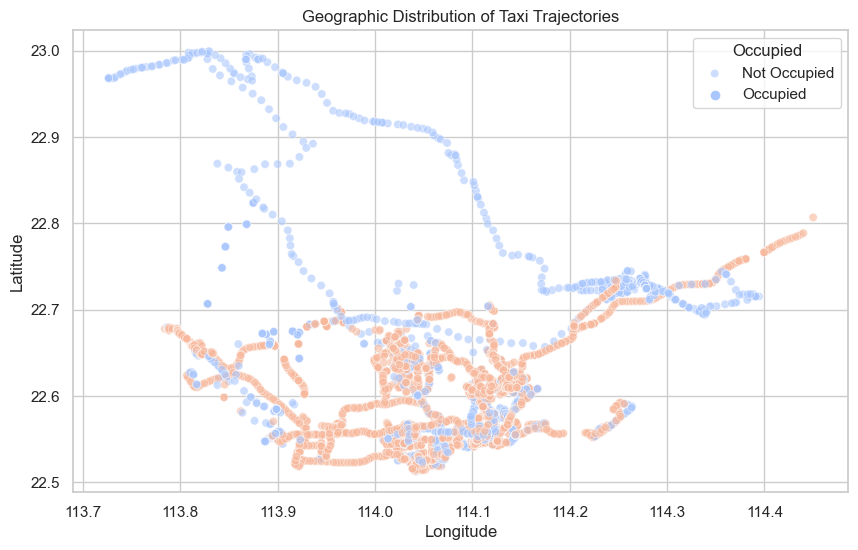

In [21]:
# Plotting geographic distribution of the taxis
plt.figure(figsize=[10, 6])
sns.scatterplot(data=taxi_data, x='Longitude', y='Latitude', hue='Occupied', palette='coolwarm', alpha=0.6)
plt.title('Geographic Distribution of Taxi Trajectories')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Occupied', labels=['Not Occupied', 'Occupied'])
plt.show()

<Figure size 1400x800 with 0 Axes>

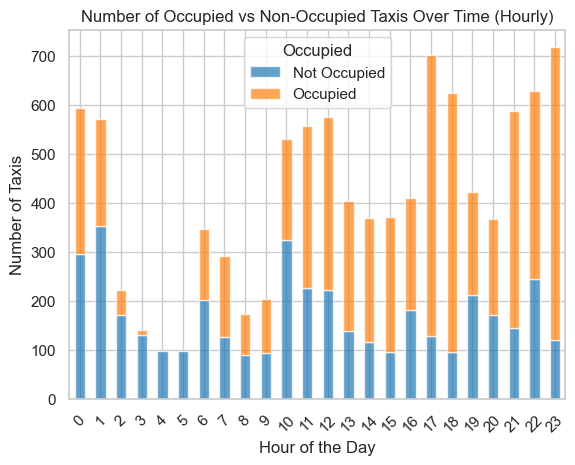

In [22]:
# Convert 'Timestamp' to a more usable form, then perform time-based analysis
taxi_data['Hour'] = pd.to_datetime(taxi_data['Timestamp'], format='%H:%M:%S').dt.hour
hourly_occupancy = taxi_data.groupby(['Hour', 'Occupied']).size().unstack(fill_value=0)

plt.figure(figsize=[14, 8])
hourly_occupancy.plot(kind='bar', stacked=True, color=['#1f77b4', '#ff7f0e'], alpha=0.7)
plt.title('Number of Occupied vs Non-Occupied Taxis Over Time (Hourly)')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Taxis')
plt.legend(title='Occupied', labels=['Not Occupied', 'Occupied'])
plt.xticks(rotation=45)
plt.show()

In this part, I used the Shenzhen taxi trajectory data set from Baidu Paddle Dataset. I used summary info function to see the dataset. Since this data does not provide column names, I need to assign names to these columns based on the assumed structure and then proceed with analysis and visualization.

The summary of the taxi trajectories data reveals:
1. **Unique Taxis**: There are 5 unique taxis represented in the dataset.
2. **Time Range**: The timestamps range from 00:00:00 to 23:59:58, suggesting the data covers a full day's activity.
3. **Record Count**: There are 10,000 records in the dataset.
4. **Occupancy Info**: About 59.18% of the records indicate the taxi was occupied (1), while 40.82% indicate it was not occupied (0).

I also visualized one unkonwn column with a histogram to understand the distribution of the 'Unknown' numerical value, which might give us clues about what it represents. The histogram of the 'Unknown' numerical values shows a skewed distribution with a concentration of values at the lower end and a long tail extending to higher values. This pattern could represent several different things, such as speed, where most of the time taxis move at lower speeds with occasional higher speeds, or it could represent something like distance to the next job or time since the last fare for each taxi. 

Visualization of the geographic locations represented by the latitude and longitude to see the coverage area of these taxis. The taxis cover a wide range of areas, suggesting they move throughout a large part of the city or region.The taxis cover a wide range of areas, suggesting they move throughout a large part of the city or region.